## Code Testing the Rolling Window Cross-Validation in Sktime

***

First we import the necessary modules.

In [27]:
from sktime.datasets import load_airline
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error, MeanAbsoluteError
from sktime.forecasting.model_selection import ForecastingGridSearchCV, ExpandingWindowSplitter, SlidingWindowSplitter
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

import lightgbm
import numpy as np

We import the airline passenger data stored in sktime, set our forecast horizon, and split into a train and test set.

In [28]:
y = load_airline()
fh = np.arange(1, 2)
y_train, y_test = temporal_train_test_split(y, test_size=len(fh))

We're going to be testing a light gradient boosted machine.

In [29]:
regressor = lightgbm.LGBMRegressor()

We can define a `forecaster` that automatically performs reduction (we're using recursive strategy here) with a specific `window_length`, i.e., the LGBM model takes the `window_length` features as input and predicts one step ahead.

In [30]:
forecaster = make_reduction(regressor, window_length=12, strategy="recursive")

Now we just fit the model, generate our forecast(s), plot, and calculate the error.

45.59563408695061

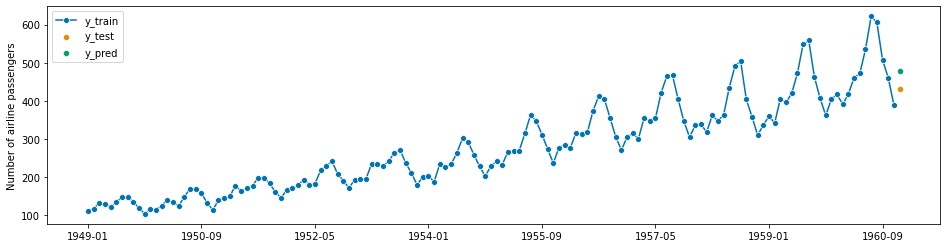

In [31]:
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_error(y_test, y_pred)

***

We're going to ramp things up on the forecasting model - let's detrend and deseasonalize the data prior to forecasting. This will improve the performance of the LGBM.

In [36]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender()),
        ("forecast", make_reduction(regressor, window_length=12, strategy="recursive"))
    ]
)

Next, we implement a rolling window cross-validation strategy for choosing hyper-parameters. We leave all parameters of the actual LGBM regressor as the default values, we are simply going to be optimizing the length of the input window of data.

In [37]:
# param_grid = {"forecast__window_length": [14, 15, 16]}
param_grid = {'forecast__estimator__learning_rate': [0.05, 0.075, 0.1, 0.125, 0.15],
              'forecast__estimator__n_estimators': [100, 200, 300, 400, 500]}

The first step is to define a `sliding window splitter`. The `SlidingWindowSplitter()` function takes the following arguments:

* fh = forecast horizon (default of 1)
* window_length = length of training data window
* step_length = number of periods to roll forward per window (default of 1)

In [38]:
cv = ExpandingWindowSplitter(fh=fh, initial_window=int(np.floor(0.7*len(y_train))), start_with_window=True)

In [39]:
gscv = ForecastingGridSearchCV(forecaster, strategy="refit", cv=cv, param_grid=param_grid, scoring=MeanAbsoluteError())

7.919585210252592

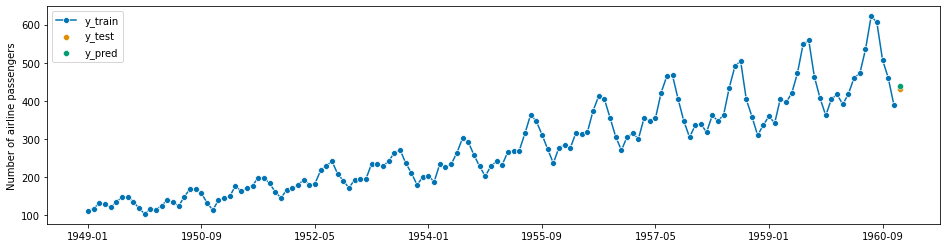

In [40]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_error(y_test, y_pred)

In [41]:
gscv.best_params_

{'forecast__estimator__learning_rate': 0.05,
 'forecast__estimator__n_estimators': 100}

In [42]:
gscv.cv_results_

,mean_test_MeanAbsoluteError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsoluteError
0,17.648183,0.052167,0.009987,"{'forecast__estimator__learning_rate': 0.05, '...",1.0
1,17.844634,0.068573,0.010052,"{'forecast__estimator__learning_rate': 0.05, '...",3.0
2,18.085529,0.087622,0.010297,"{'forecast__estimator__learning_rate': 0.05, '...",8.0
3,18.091910,0.109135,0.010627,"{'forecast__estimator__learning_rate': 0.05, '...",9.0
4,18.094668,0.122147,0.009906,"{'forecast__estimator__learning_rate': 0.05, '...",10.0
5,17.799992,0.053573,0.010302,"{'forecast__estimator__learning_rate': 0.075, ...",2.0
6,18.028032,0.072982,0.010544,"{'forecast__estimator__learning_rate': 0.075, ...",7.0
7,18.108473,0.092871,0.010883,"{'forecast__estimator__learning_rate': 0.075, ...",11.0
8,18.142315,0.135530,0.012452,"{'forecast__estimator__learning_rate': 0.075, ...",14.0
9,18.216108,0.152414,0.012180,"{'forecast__estimator__learning_rate': 0.075, ...",16.0


In [13]:
gscv.get_params()

{'cv': ExpandingWindowSplitter(fh=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23]),
             initial_window=None),
 'forecaster__steps': [('deseasonalize',
   Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender()),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(),
                                        window_length=15))],
 'forecaster__deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'forecaster__detrend': Detrender(),
 'forecaster__forecast': RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(),
                                      window_length=15),
 'forecaster__deseasonalize__model': 'multiplicative',
 'forecaster__deseasonalize__sp': 12,
 'forecaster__detrend__forecaster': None,
 'forecaster__forecast__estimator__boosting_type': 'gbdt',
 'forecaster__forecast__estimator__class_weight': None,
 'forecaster__forecast__estimator__colsample_bytr